# Relation extraction with BERT

---

The goal of this notebook is to show how to use [BERT](https://arxiv.org/abs/1810.04805)
to [extract relation](https://en.wikipedia.org/wiki/Relationship_extraction) from text.

Used libraries:
- [PyTorch](https://pytorch.org/)
- [PyTorch-Lightning](https://pytorch-lightning.readthedocs.io/en/latest/)
- [Transformers](https://huggingface.co/transformers/index.html)

Used datasets:
- SemEval 2010 Task 8 - [paper](https://arxiv.org/pdf/1911.10422.pdf) - [download](https://github.com/sahitya0000/Relation-Classification/blob/master/corpus/SemEval2010_task8_all_data.zip?raw=true)
- Google IISc Distant Supervision (GIDS) - [paper](https://arxiv.org/pdf/1804.06987.pdf) - [download](https://drive.google.com/open?id=1gTNAbv8My2QDmP-OHLFtJFlzPDoCG4aI)
- Riedel's New York Times - [paper](https://www.researchgate.net/publication/220698997_Modeling_Relations_and_Their_Mentions_without_Labeled_Text) - [download](https://drive.google.com/uc?id=1D7bZPvrSAbIPaFSG7ZswYQcPA3tmouCw&export=download)

## Install dependencies

This project uses [Python 3.7+](https://www.python.org/downloads/release/python-378/)

In [1]:
!pip install requests==2.23.0 numpy==1.18.5 pandas==1.0.3 \
    scikit-learn==0.23.1 pytorch-lightning==0.8.4 torch==1.5.1 \
    transformers==3.0.2 sklearn==0.0 tqdm==4.45.0 neptune-client==0.4.119 \
    matplotlib==3.1.0 scikit-plot==0.3.7

     |████████████████████████████████| 304 kB 584 kB/s eta 0:00:01
     |████████████████████████████████| 769 kB 1.8 MB/s eta 0:00:01
     |████████████████████████████████| 90 kB 2.2 MB/s eta 0:00:011
     |████████████████████████████████| 13.1 MB 3.0 MB/s eta 0:00:01
     |████████████████████████████████| 3.0 MB 3.1 MB/s eta 0:00:01
     |████████████████████████████████| 55 kB 1.7 MB/s eta 0:00:01
     |████████████████████████████████| 67 kB 2.4 MB/s eta 0:00:011
     |████████████████████████████████| 138 kB 3.5 MB/s eta 0:00:01


  Created wheel for neptune-client: filename=neptune_client-0.4.119-py2.py3-none-any.whl size=150019 sha256=12a272db1f274c3955de25676e6d1a45cebd13e0489e5f064ce28f4ec39e460a
  Stored in directory: /root/.cache/pip/wheels/64/3b/7e/69f84d99e2109788f757ef707b3ea51921f16891e42929eb31
  Created wheel for msgpack-python: filename=msgpack_python-0.5.6-cp37-cp37m-linux_x86_64.whl size=302595 sha256=1e19c05a4cc5bc61bb26b648dcb492c6e0799777c8555aaf059f383a0e1c818b
  Stored in directory: /root/.cache/pip/wheels/f8/6c/02/92ebc97f3b99ad5bfc675be2c513f9cb3504fdbe338314f377
  Created wheel for strict-rfc3339: filename=strict_rfc3339-0.7-py3-none-any.whl size=18119 sha256=8ecd77b8e7e4568f89918658fe05097e13f831d30e0e11982725ba99526e8b46
  Stored in directory: /root/.cache/pip/wheels/f3/1d/9f/2a74caecb81b8beb9a4fbe1754203d4b7cf42ef5d39e0d2311
Successfully built neptune-client msgpack-python strict-rfc3339
ERROR: plotnine 0.7.0 has requirement matplotlib>=3.1.1, but you'll have matplotlib 3.1.0 which is i

## Import needed modules

In [58]:
import gc
import json
import math
import os
import shutil
import zipfile
from abc import ABC, abstractmethod
from collections import OrderedDict
from typing import TextIO, Iterable, Tuple
from urllib.parse import urlparse

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import torch
from pandas import DataFrame
from pytorch_lightning import LightningModule, seed_everything, Callback
from pytorch_lightning import Trainer as LightningTrainer
from pytorch_lightning.logging.neptune import NeptuneLogger
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, \
    roc_curve, roc_auc_score, precision_recall_curve, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import column_or_1d
from torch import Tensor, nn
from torch.nn import functional as F
from torch.optim import AdamW
from torch.optim.lr_scheduler import LambdaLR
from torch.utils.data import DataLoader, IterableDataset
from tqdm.auto import tqdm
from transformers import *

## Define constants

In [4]:
# --- Random seed ---
SEED = 2020
seed_everything(SEED)

# --- Neptune logger ---
NEPTUNE_API_TOKEN="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vdWkubmVwdHVuZS5haSIsImFwaV91cmwiOiJodHRwczovL3VpLm5lcHR1bmUuYWkiLCJhcGlfa2V5IjoiMTU3YTAxMjctYWQwOC00YTU4LTk5Y2ItM2JmNjJmNDJjY2VkIn0="
NEPTUNE_PROJECT_NAME="hung/bert-relation-extraction"

# --- Directory ---
ROOT_DIR = os.path.abspath('.')
PROCESSED_DATA_DIR = os.path.join(ROOT_DIR, 'data/processed') 
METADATA_FILE_NAME = os.path.join(PROCESSED_DATA_DIR, 'metadata.json')
CHECKPOINT_DIR = os.path.join(ROOT_DIR, 'checkpoint')

# in local environment
RAW_DATA_DIR =  os.path.join(ROOT_DIR, 'data/raw')

# in Kaggle environment
# 3 datasets should already been added to the notebook
RAW_DATA_DIR = os.path.join(ROOT_DIR, '../input')

# --- Datasets ---
DATASET_MAPPING = {
    'SemEval2010Task8': {
        'dir': os.path.join(RAW_DATA_DIR,'semeval2010-task-8'),
        'extract_dir': os.path.join(RAW_DATA_DIR, 'SemEval2010_task8_all_data'),
        'url': 'https://github.com/sahitya0000/Relation-Classification/'
               'blob/master/corpus/SemEval2010_task8_all_data.zip?raw=true',
        'fit_in_memory': True
    },
    'GIDS': {
        'dir': os.path.join(RAW_DATA_DIR,'gids-dataset'),
        'extract_dir': os.path.join(RAW_DATA_DIR, 'gids_data'),
        'url': 'https://drive.google.com/uc?id=1gTNAbv8My2QDmP-OHLFtJFlzPDoCG4aI&export=download',
        'fit_in_memory': True
    },
    'NYT': {
        'dir': os.path.join(RAW_DATA_DIR,'nyt-relation-extraction'),
        'extract_dir': os.path.join(RAW_DATA_DIR, 'riedel_data'),
        'url': 'https://drive.google.com/uc?id=1D7bZPvrSAbIPaFSG7ZswYQcPA3tmouCw&export=download',
        'fit_in_memory': False
    }
}

# change this variable to switch dataset in later tasks
DATASET_NAME = 'SemEval2010Task8'

# --- BERT ---
SUB_START_CHAR = '['
SUB_END_CHAR = ']'
OBJ_START_CHAR = '{'
OBJ_END_CHAR = '}'

# --- BERT Model ---
# See https://huggingface.co/transformers/pretrained_models.html for the full list
AVAILABLE_PRETRAINED_MODELS = [
    'distilbert-base-uncased', 
    'distilbert-base-cased', 
    'distilgpt2', 
    'bert-base-uncased',
    'roberta-base'
]

# change this variable to switch pretrained language model in later tasks
PRETRAINED_MODEL = AVAILABLE_PRETRAINED_MODELS[0]

# if e1 is not related to e2, should "e2 not related to e1" be added to the trainning set
ADD_REVERSE_RELATIONSHIP = False

## Download data

This part **CAN BE SKIPPED** if this notebook is running on Kaggle environment since the dataset has already been included.

First, we install `gdown` to download files from Google Drive

In [ ]:
#!pip install gdown==3.11.1
#import gdown

Some download util functions:

In [ ]:
def download_from_url(url: str, save_path: str, chunk_size: int = 2048):
    with open(save_path, "wb") as f:
        print(f"Downloading...\nFrom: {url}\nTo: {save_path}")
        response = requests.get(url, stream=True)
        for data in tqdm(response.iter_content(chunk_size=chunk_size)):
            f.write(data)

def download_from_google_drive(url: str, save_path: str):
    gdown.download(url, save_path, use_cookies=False)

def extract_zip(zip_file_path: str, extract_dir: str, remove_zip_file: bool = True):
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        print("Extracting to " + extract_dir)
        for member in tqdm(zip_ref.infolist()):
            zip_ref.extract(member, extract_dir)

    if remove_zip_file:
        print("Removing zip file")
        os.unlink(zip_file_path)

The download function itself:

In [ ]:
def download(dataset_name: str, dataset_url: str, dataset_dir: str, dataset_extract_dir: str, force_redownload: bool):
    print(f"\n---> Downloading dataset {dataset_name} <---")
    
    # create raw data dir
    if not os.path.exists(RAW_DATA_DIR):
        print("Creating raw data directory " + RAW_DATA_DIR)
        os.makedirs(RAW_DATA_DIR)
    
    # check data has been downloaded
    if os.path.exists(dataset_dir):
        if force_redownload:
            print(f"Removing old raw data {dataset_dir}")
            shutil.rmtree(dataset_dir)
        else:
            print(f"Directory {dataset_dir} exists, skip downloading.")
            return


    # download
    tmp_file_path = os.path.join(RAW_DATA_DIR, dataset_name + '.zip')
    if urlparse(dataset_url).netloc == 'drive.google.com':
        download_from_google_drive(dataset_url, tmp_file_path)
    else:
        download_from_url(dataset_url, tmp_file_path)

    # unzip
    extract_zip(tmp_file_path, RAW_DATA_DIR)

    # rename
    os.rename(dataset_extract_dir, dataset_dir)

Download all datasets:

In [ ]:
def download_all_dataset():
    for dataset_name, dataset_info in DATASET_MAPPING.items():
        download(
            dataset_name,
            dataset_url=dataset_info['url'],
            dataset_dir=dataset_info['dir'],
            dataset_extract_dir=dataset_info['extract_dir'],
            force_redownload=False
        )

#download_all_dataset()

## Preprocess

In [5]:
class OrdinalLabelEncoder:
    def __init__(self, init_labels=None):
        if init_labels is None:
            init_labels = []
        self.mapping = OrderedDict({l: i for i, l in enumerate(init_labels)})

    @property
    def classes_(self):
        return list(self.mapping.keys())

    def fit_transform(self, y):
        return self.fit(y).transform(y)

    def fit(self, y):
        y = column_or_1d(y, warn=True)
        new_classes = pd.Series(y).unique()
        for cls in new_classes:
            if cls not in self.mapping:
                self.mapping[cls] = len(self.mapping)
        return self

    def transform(self, y):
        y = column_or_1d(y, warn=True)
        return [self.mapping[value] for value in y]
    
    
class AbstractPreprocessor(ABC):
    DATASET_NAME = ''
    VAL_DATA_PROPORTION = 0.2
    NO_RELATION_LABEL = ''

    def __init__(self, tokenizer: PreTrainedTokenizer):
        self.tokenizer = tokenizer
        self.SUB_START_ID, self.SUB_END_ID, self.OBJ_START_ID, self.OBJ_END_ID \
            = tokenizer.convert_tokens_to_ids([SUB_START_CHAR, SUB_END_CHAR, OBJ_START_CHAR, OBJ_END_CHAR])

    def preprocess_data(self, reprocess: bool):
        print(f"\n---> Preprocessing {self.DATASET_NAME} dataset <---")
        
        # create processed data dir
        if not os.path.exists(PROCESSED_DATA_DIR):
            print("Creating processed data directory " + PROCESSED_DATA_DIR)
            os.makedirs(PROCESSED_DATA_DIR)

        # stop preprocessing if file existed
        json_file_names = [self.get_json_file_name(k) for k in ('train', 'val', 'test')]
        existed_files = [fn for fn in json_file_names if os.path.exists(fn)]
        if existed_files:
            file_text = "- " + "\n- ".join(existed_files)
            if not reprocess:
                print("The following files already exist:")
                print(file_text)
                print("Preprocessing is skipped. See option --reprocess.")
                return
            else:
                print("The following files will be overwritten:")
                print(file_text)

        self._preprocess_data()
        self._create_secondary_data_files()

        print("---> Done ! <---")

    @abstractmethod
    def _preprocess_data(self):
        pass

    def _create_secondary_data_files(self):
        with open(METADATA_FILE_NAME) as f:
            root_metadata = json.load(f)
            metadata = root_metadata[self.DATASET_NAME]

        related_only_count = {
            'train': 0,
            'val': 0,
            'test': 0,
        }

        for key in ['train', 'test', 'val']:
            print(f"Creating secondary files for {key} data")

            origin_file = open(self.get_json_file_name(key))
            bin_file = open(self.get_json_file_name(f'{key}_binary'), "w")
            related_file = open(self.get_json_file_name(f'{key}_related_only'), "w")

            total = metadata[f'{key}_size']

            for line in tqdm(origin_file, total=total):
                data = json.loads(line)
                if data['label'] != 0:
                    related_only_count[key] += 1
                    data['label'] -= 1
                    related_file.write(json.dumps(data) + "\n")
                    data['label'] = 1
                    bin_file.write(json.dumps(data) + "\n")
                else:
                    bin_file.write(json.dumps(data) + "\n")

            origin_file.close()
            bin_file.close()
            related_file.close()

        print("Updating metadata.json")
        for key in ['train', 'test', 'val']:
            metadata[f'{key}_related_only_size'] = related_only_count[key]
        root_metadata[self.DATASET_NAME] = metadata
        with open(METADATA_FILE_NAME, "w") as f:
            json.dump(root_metadata, f, indent=4)

    def _find_sub_obj_pos(self, input_ids_list: Iterable) -> DataFrame:
        sub_start_pos = [self._index(s, self.SUB_START_ID) + 1 for s in input_ids_list]
        sub_end_pos = [self._index(s, self.SUB_END_ID, sub_start_pos[i]) for i, s in enumerate(input_ids_list)]
        obj_start_pos = [self._index(s, self.OBJ_START_ID) + 1 for s in input_ids_list]
        obj_end_pos = [self._index(s, self.OBJ_END_ID, obj_start_pos[i]) for i, s in enumerate(input_ids_list)]
        return DataFrame({
            'sub_start_pos': sub_start_pos,
            'sub_end_pos': sub_end_pos,
            'obj_start_pos': obj_start_pos,
            'obj_end_pos': obj_end_pos,
        })

    def _index(self, lst: list, ele: int, start: int = 0) -> int:
        try:
            return lst.index(ele, start)
        except ValueError:
            return -1

    def _remove_invalid_sentences(self, data: DataFrame) -> DataFrame:
        seq_max_len = self.tokenizer.model_max_length
        return data.loc[
            (data['sub_end_pos'] < seq_max_len)
            & (data['obj_end_pos'] < seq_max_len)
            & (data['sub_end_pos'] > -1)
            & (data['obj_end_pos'] > -1)
        ]

    def _get_label_mapping(self, le: LabelEncoder):
        # ignore id 0, which represent no relation
        id_to_label = dict(enumerate(le.classes_))
        label_to_id = {v: k for k, v in id_to_label.items()}
        id_to_label_related_only = {k - 1: v for k, v in id_to_label.items() if k != 0}
        label_to_id_related_only = {v: k for k, v in id_to_label_related_only.items()}
        return {
            'id_to_label': id_to_label,
            'label_to_id': label_to_id,
            'id_to_label_related_only': id_to_label_related_only,
            'label_to_id_related_only': label_to_id_related_only,            
        }

    def _append_data_to_file(self, data: DataFrame, file: TextIO):
        lines = ""
        for _, row in data.iterrows():
            lines += row.to_json() + "\n"
        file.write(lines)

    def _save_metadata(self, metadata: dict):
        # create metadata file
        if not os.path.exists(METADATA_FILE_NAME):
            print(f"Create metadata file at {METADATA_FILE_NAME}")
            with open(METADATA_FILE_NAME, 'w') as f:
                f.write("{}\n")

        # add metadata
        print("Saving metadata")
        with open(METADATA_FILE_NAME) as f:
            root_metadata = json.load(f)
        with open(METADATA_FILE_NAME, 'w') as f:
            root_metadata[self.DATASET_NAME] = metadata
            json.dump(root_metadata, f, indent=4)

    def _get_label_encoder(self) -> LabelEncoder:
        le = OrdinalLabelEncoder()
        le.fit_transform([self.NO_RELATION_LABEL]) # make sure that no relation has id 0
        return le

    @classmethod
    def get_json_file_name(cls, key: str) -> str:
        return os.path.join(PROCESSED_DATA_DIR, f'{cls.DATASET_NAME.lower()}_{key}.json')

class SemEval2010Task8Preprocessor(AbstractPreprocessor):
    DATASET_NAME = 'SemEval2010Task8'
    NO_RELATION_LABEL = 'Other'
    RAW_TRAIN_FILE_NAME = os.path.join(DATASET_MAPPING['SemEval2010Task8']['dir'],
                                       'SemEval2010_task8_training/TRAIN_FILE.TXT')
    RAW_TEST_FILE_NAME = os.path.join(DATASET_MAPPING['SemEval2010Task8']['dir'],
                                      'SemEval2010_task8_testing_keys/TEST_FILE_FULL.TXT')
    RAW_TRAIN_DATA_SIZE = 8000
    RAW_TEST_DATA_SIZE = 2717

    def _preprocess_data(self):
        print("Processing training data")
        train_data = self._get_data_from_file(
            self.RAW_TRAIN_FILE_NAME,
            self.RAW_TRAIN_DATA_SIZE
        )

        print("Processing test data")
        test_data = self._get_data_from_file(
            self.RAW_TEST_FILE_NAME,
            self.RAW_TEST_DATA_SIZE
        )

        print("Encoding labels to integers")
        le = self._get_label_encoder()
        train_data['label'] = le.fit_transform(train_data['label'])
        test_data['label'] = le.transform(test_data['label'])

        print("Splitting train & validate data")
        train_data, val_data = train_test_split(train_data, shuffle=True, random_state=SEED)

        print("Saving to json files")
        with open(self.get_json_file_name('train'), 'w') as f:
            self._append_data_to_file(train_data, f)
        with open(self.get_json_file_name('val'), 'w') as f:
            self._append_data_to_file(val_data, f)
        with open(self.get_json_file_name('test'), 'w') as f:
            self._append_data_to_file(test_data, f)

        self._save_metadata({
            'train_size': len(train_data),
            'val_size': len(val_data),
            'test_size': len(test_data),
            'no_relation_label': self.NO_RELATION_LABEL,
            **self._get_label_mapping(le)
        })

    def _get_data_from_file(self, file_name: str, dataset_size: int, reverse: bool = ADD_REVERSE_RELATIONSHIP) -> DataFrame:
        raw_sentences = []
        labels = []
        with open(file_name) as f:
            for _ in tqdm(range(dataset_size)):
                sent = f.readline()
                label, sub, obj = self._process_label(f.readline())
                labels.append(label)
                raw_sentences.append(self._process_sentence(sent, sub, obj))
                if label == 'Other' and reverse:
                    labels.append(label)
                    raw_sentences.append(self._process_sentence(sent, obj, sub))
                f.readline()
                f.readline()
        tokens = self.tokenizer(raw_sentences, truncation=True, padding='max_length')
        data = DataFrame(tokens.data)
        data['label'] = labels
        sub_obj_position = self._find_sub_obj_pos(data['input_ids'])
        data = pd.concat([data, sub_obj_position], axis=1)
        data = self._remove_invalid_sentences(data)
        return data

    def _process_sentence(self, sentence: str, sub: int, obj: int) -> str:
        return sentence.split("\t")[1][1:-2] \
            .replace(f"<e{sub}>", SUB_START_CHAR) \
            .replace(f"</e{sub}>", SUB_END_CHAR) \
            .replace(f"<e{obj}>", OBJ_START_CHAR) \
            .replace(f"</e{obj}>", OBJ_END_CHAR)

    def _process_label(self, label: str) -> Tuple[str, int, int]:
        label = label.strip()
        if label == 'Other':
            return label, 1, 2
        nums = list(filter(str.isdigit, label))
        return label, int(nums[0]), int(nums[1])

class LargeDatasetPreprocessor(AbstractPreprocessor):
    PROCESS_BATCH_SIZE = 2**12
    NO_RELATION_LABEL = 'NA'

    def _preprocess_data(self):
        pass

    def _process_batch(self, le: LabelEncoder, in_file: TextIO) -> DataFrame:
        raw_sentences = []
        labels = []

        for _ in range(self.PROCESS_BATCH_SIZE):
            dt = in_file.readline()
            if dt == "": break # EOF
            dt = json.loads(dt)

            # add subject markup
            sub = dt['sub']  # TODO keep _ or not?
            obj = dt['obj']
            new_sub = SUB_START_CHAR + ' ' + sub.replace("_", "") + ' ' + SUB_END_CHAR
            new_obj = OBJ_START_CHAR + ' ' +  obj.replace("_", "") + ' ' + OBJ_END_CHAR
            self._replace_once(dt['sent'], sub, new_sub)
            self._replace_once(dt['sent'], obj, new_obj)
            raw_sentences.append(" ".join(dt['sent']))
            labels.append(dt['rel'])

        if not raw_sentences:
            return DataFrame()

        tokens = self.tokenizer(raw_sentences, truncation=True, padding='max_length')
        data = DataFrame(tokens.data)
        print("*", set(labels))
        data['label'] = le.fit_transform(labels)
        print("#", set(data['label']))
        sub_obj_position = self._find_sub_obj_pos(data['input_ids'])
        data = pd.concat([data, sub_obj_position], axis=1)
        data = self._remove_invalid_sentences(data)
        return data

    def _replace_once(self, arr: list, element, replacement):
        for i, e in enumerate(arr):
            if e == element:
                arr[i] = replacement
                return
            if e[:-1] == element and e[-1] in ',.?!;:':
                arr[i] = replacement + e[-1]
                return

    def _process_subset(self, le: LabelEncoder, in_file_name, out_file_name, data_size) -> int:
        total_data_size = 0
        s = set()
        with open(in_file_name) as in_file, open(out_file_name, 'w') as out_file:
            batch_count = math.ceil(data_size / self.PROCESS_BATCH_SIZE)
            for _ in tqdm(range(batch_count)):
                data = self._process_batch(le, in_file)
                s.update(data['label'])
                self._append_data_to_file(data, out_file)
                total_data_size += len(data)
        print(s)
        return total_data_size

class GIDSPreprocessor(LargeDatasetPreprocessor):
    DATASET_NAME = 'GIDS'
    RAW_TRAIN_FILE_NAME = os.path.join(DATASET_MAPPING['GIDS']['dir'], 'gids_train.json')
    RAW_VAL_FILE_NAME = os.path.join(DATASET_MAPPING['GIDS']['dir'], 'gids_dev.json')
    RAW_TEST_FILE_NAME = os.path.join(DATASET_MAPPING['GIDS']['dir'], 'gids_test.json')
    TRAIN_SIZE = 11297
    VAL_SIZE = 1864
    TEST_SIZE = 5663
    PROCESS_BATCH_SIZE = 1024

    def _preprocess_data(self):
        le = self._get_label_encoder()
        
        print("Process train dataset")
        actual_train_size = self._process_subset(
            le,
            self.RAW_TRAIN_FILE_NAME,
            self.get_json_file_name('train'),
            self.TRAIN_SIZE
        )
        print(">>> ", le.classes_)

        print("Process val dataset")
        actual_val_size = self._process_subset(
            le,
            self.RAW_VAL_FILE_NAME,
            self.get_json_file_name('val'),
            self.VAL_SIZE
        )
        print(">>> ", le.classes_)
        
        print("Process test dataset")
        actual_test_size = self._process_subset(
            le, 
            self.RAW_TEST_FILE_NAME, 
            self.get_json_file_name('test'),
            self.TEST_SIZE
        )
        print(">>> ", le.classes_)

        self._save_metadata({
            'train_size': actual_train_size,
            'val_size': actual_val_size,
            'test_size': actual_test_size,
            'no_relation_label': self.NO_RELATION_LABEL,
            **self._get_label_mapping(le)
        })

class NYTPreprocessor(LargeDatasetPreprocessor):
    DATASET_NAME = 'NYT'
    RAW_TRAIN_FILE_NAME = os.path.join(DATASET_MAPPING['NYT']['dir'], 'riedel_train.json')
    RAW_TEST_FILE_NAME = os.path.join(DATASET_MAPPING['NYT']['dir'], 'riedel_test.json')
    TRAIN_SIZE = 570084
    TEST_SIZE = 172448
    PROCESS_BATCH_SIZE = 4096 * 4

    def _preprocess_data(self):
        le = self._get_label_encoder()
        actual_train_size = 0
        actual_val_size = 0

        print("Process train & val dataset")
        batch_count = math.ceil(self.TRAIN_SIZE / self.PROCESS_BATCH_SIZE)
        with open(self.RAW_TRAIN_FILE_NAME) as in_file,\
                open(self.get_json_file_name('train'), 'w') as train_file,\
                open(self.get_json_file_name('val'), 'w') as val_file:
                    for _ in tqdm(range(batch_count)):
                        data = self._process_batch(le, in_file)
                        train_data, val_data = train_test_split(data, shuffle=True, random_state=SEED)
                        self._append_data_to_file(train_data, train_file)
                        self._append_data_to_file(val_data, val_file)
                        actual_train_size += len(train_data)
                        actual_val_size += len(val_data)

        print("Process test dataset")
        actual_test_size = self._process_subset(
            le, 
            self.RAW_TEST_FILE_NAME, 
            self.get_json_file_name('test'),
            self.TEST_SIZE
        )

        self._save_metadata({
            'train_size': actual_train_size,
            'val_size': actual_val_size,
            'test_size': actual_test_size,
            'no_relation_label': self.NO_RELATION_LABEL,
            **self._get_label_mapping(le)
        })
        

def get_preprocessor_class(dataset_name: str = DATASET_NAME):
    return globals()[f'{dataset_name}Preprocessor']
        
def get_preprocessor(dataset_name: str = DATASET_NAME)-> AbstractPreprocessor:
    tokenizer = AutoTokenizer.from_pretrained(PRETRAINED_MODEL, use_fast=True)
    preprocessors_class = get_preprocessor_class(dataset_name)
    return preprocessors_class(tokenizer)

In [6]:
preprocessor = get_preprocessor()
preprocessor.preprocess_data(reprocess=True)



---> Preprocessing SemEval2010Task8 dataset <---
Creating processed data directory /kaggle/working/data/processed
Processing training data



Processing test data



Encoding labels to integers
Splitting train & validate data
Saving to json files
Create metadata file at /kaggle/working/data/processed/metadata.json
Saving metadata
Creating secondary files for train data



Creating secondary files for test data



Creating secondary files for val data



Updating metadata.json
---> Done ! <---


## Model

### Dataset

In [7]:
class GenericDataset(IterableDataset):

    def __init__(self, dataset_name: str, subset: str, batch_size: int, label_transform: str):
        assert subset in ['train', 'val', 'test']
        assert label_transform in ['none', 'binary', 'related_only']

        file_name = subset if label_transform == 'none' \
            else f'{subset}_{label_transform}'

        preprocessor_class = get_preprocessor_class()
        with open(METADATA_FILE_NAME) as f:
            metadata = json.load(f)[dataset_name]

        size = metadata[f'{subset}_related_only_size'] \
            if label_transform is 'related_only' \
            else metadata[f'{subset}_size']

        self.length = math.ceil(size / batch_size)
        self.fit_in_memory = DATASET_MAPPING[dataset_name]['fit_in_memory']
        self.file = open(preprocessor_class.get_json_file_name(file_name))

    def __del__(self):
        if self.file:
            self.file.close()

    def __iter__(self):
        if self.fit_in_memory:
            lines = self.file.readlines()
        else:
            lines = self.file

        def get_data():
            for line in lines:
                data = json.loads(line)
                input_data = {k: torch.tensor(v) for k, v in data.items() if k != 'label'}
                label = torch.tensor(data['label'])
                yield input_data, label

        return get_data()
    
    def __len__(self):
        return self.length

### Torch Lightning Module

In [68]:
def get_activation_layer(activate_func_name):
    return getattr(nn, activate_func_name)()

class BaseModule(LightningModule, ABC):
    def __init__(self, dataset_label_transform):
        super().__init__()
        self.proposed_answer = None
        self.hparams.dataset_label_transform = self.dataset_label_transform = dataset_label_transform
    
    @abstractmethod
    def loss_function(self, y_hat, label):
        pass
    
    @abstractmethod
    def log_metrics(self, epoch_type, y_hat, label) -> dict:
        pass
    
    @abstractmethod
    def decay_lr(self, epoch):
        pass

    def train_dataloader(self) -> DataLoader:
        return self.__get_dataloader('train')

    def val_dataloader(self) -> DataLoader:
        return self.__get_dataloader('val')

    def test_dataloader(self) -> DataLoader:
        return self.__get_dataloader('test')

    def __get_dataloader(self, subset: str) -> DataLoader:
        batch_size = self.hparams.batch_size
        dataset = GenericDataset(
            self.hparams.dataset_name,
            subset, 
            batch_size, 
            self.dataset_label_transform
        )
        return DataLoader(
            dataset,
            batch_size=batch_size,
            num_workers=1
        )

    def configure_optimizers(self):
        optimizer = AdamW(
            [p for p in self.parameters() if p.requires_grad],
            lr=self.hparams.learning_rate,
            weight_decay=self.hparams.weight_decay
        )
        scheduler = LambdaLR(optimizer, self.decay_lr)
        return [optimizer], [scheduler]
    
    def training_step(self, batch, batch_nb) -> dict:
        input_data, label = batch
        y_hat = self(**input_data)

        loss = self.loss_function(y_hat, label)
        tensorboard_logs = {'train_loss': loss}

        return {'loss': loss, 'log': tensorboard_logs}

    def _eval_step(self, batch, batch_nb) -> dict:
        input_data, label = batch
        y_hat = self(**input_data)

        return {
            'y_hat': y_hat,
            'label': label,
        }
    
    def validation_step(self, batch, batch_nb) -> dict:
        return self._eval_step(batch, batch_nb)
    
    def test_step(self, batch, batch_nb) -> dict:
        return self._eval_step(batch, batch_nb)

    def _eval_epoch_end(self, epoch_type, outputs) -> dict:
        assert epoch_type in ['test', 'val']
        
        y_hat = torch.cat([x['y_hat'] for x in outputs]).cpu()
        label = torch.cat([x['label'] for x in outputs]).cpu()
        
        logs = self.log_metrics(epoch_type, y_hat, label)
        
        return {'progress_bar': logs}
    
    def validation_epoch_end(self, outputs) -> dict:
        return self._eval_epoch_end('val', outputs)

    def test_epoch_end(self, outputs) -> dict:
        return self._eval_epoch_end('test', outputs)

    def log_confusion_matrix(self, prefix, predicted_label, label):
        result = confusion_matrix(label, predicted_label)
        display = ConfusionMatrixDisplay(result)
        fig, ax = plt.subplots(figsize=(16, 12))
        display.plot(cmap=plt.cm.Blues, ax=ax)
        self.logger.experiment.log_image(f'{prefix}_confusion_matrix', fig)

class BinaryClassifier(BaseModule):

    def __init__(self, pretrained_language_model, dataset_name, batch_size, learning_rate,
                 linear_size, dropout_p, activation_function, weight_decay):
        super().__init__(dataset_label_transform="binary")
        self.save_hyperparameters()
        self.thresholds = {}

        self.language_model = AutoModel.from_pretrained(pretrained_language_model)
        self.dropout = nn.Dropout(p=dropout_p)
        self.linear = nn.Linear(self.language_model.config.hidden_size, linear_size)
        self.activation_function = get_activation_layer(activation_function)
        self.linear_output = nn.Linear(linear_size, 1)
    
    def logits_to_label(self, y, threshold):
        return (F.sigmoid(y) > threshold).long()
    
    def loss_function(self, y_hat, label):
        return F.binary_cross_entropy_with_logits(y_hat, label.float())
    
    def log_metrics(self, epoch_type, y_hat, label):
        y_hat = F.sigmoid(y_hat)
        
        if epoch_type == 'val':
            self.find_thresholds(y_hat, label)

        logs = {
            f'{epoch_type}_avg_loss': float(self.loss_function(y_hat, label)),
            f'{epoch_type}_roc_auc': roc_auc_score(label, y_hat),
        }
        
        for criteria, threshold in self.thresholds.items():
            prefix = f"{epoch_type}_{criteria}"
            predicted_label = self.logits_to_label(y_hat, threshold)
            self.log_confusion_matrix(prefix, predicted_label, label)
            
            logs[f'{prefix}_acc'] = accuracy_score(label, predicted_label)
            logs[f'{prefix}_pre'] = precision_score(label, predicted_label, average='binary')
            logs[f'{prefix}_rec'] = recall_score(label, predicted_label, average='binary')
            logs[f'{prefix}_f1'] = f1_score(label, predicted_label, average='binary')

        for k, v in logs.items():
            self.logger.experiment.log_metric(k, v)
            
        return logs
    
    def find_thresholds(self, y_hat, label):
        # best accuracy
        best_acc = 0
        best_acc_threshold = None
        for y in y_hat:
            y_predicted = self.logits_to_label(y_hat, y)
            acc = accuracy_score(label, y_predicted)
            if best_acc < acc:
                best_acc = acc
                best_acc_threshold = y
        self.thresholds['best_acc'] = best_acc_threshold
        
        # ROC curve
        # https://machinelearningmastery.com/threshold-moving-for-imbalanced-classification/
        fpr, tpr, thresholds = roc_curve(label, y_hat)
        gmeans = tpr * (1 - fpr)
        ix = np.argmax(gmeans)
        self.thresholds['best_roc'] = thresholds[ix]
        self.logger.experiment.log_metric("best_roc_threshold", thresholds[ix])

        fig, ax = plt.subplots(figsize=(16, 12))
        ax.plot([0,1], [0,1], linestyle='--', label='No Skill')
        ax.plot(fpr, tpr, marker='.', label='Logistic')
        ax.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.legend()
        self.logger.experiment.log_image('roc_curve', fig)
        
        # precision recall curve
        # https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/
        pre, rec, thresholds = precision_recall_curve(label, y_hat)
        f1s = 2 * pre * rec / (pre + rec)
        ix = np.argmax(f1s)
        self.thresholds['best_f1'] = thresholds[ix]
        self.logger.experiment.log_metric("best_f1_threshold", thresholds[ix])

        fig, ax = plt.subplots(figsize=(16, 12))
        no_skill = len(label[label == 1]) / len(label)
        ax.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
        ax.plot(rec, pre, marker='.', label='Logistic')
        ax.scatter(rec[ix], pre[ix], marker='o', color='black', label='Best F1')
        ax.set_xlabel('Recall') 
        ax.set_ylabel('Precision')
        ax.legend()
        self.logger.experiment.log_image('pre_rec_curve', fig)
        
        # log thresholds
        for k, v in self.thresholds.items():
            self.logger.experiment.log_metric(f'threshold_{k}', v)
    
    def decay_lr(self, epoch):
        return [1, 1, 0.75, 0.5, 0.25, 0.1, 0.075, 0.05, 0.025, 0.01][epoch]
    
    def forward(self, input_ids, attention_mask, sub_start_pos, sub_end_pos,
                obj_start_pos, obj_end_pos) -> Tensor:
        language_model_output, = self.language_model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )

        x = torch.mean(language_model_output, dim=1)
        x = self.dropout(x)
        x = self.linear(x)
        x = self.activation_function(x)
        x = self.dropout(x) # ??
        logits = self.linear_output(x).reshape(-1)

        return logits

class RelationClassifier(BaseModule):

    def __init__(self, pretrained_language_model, dataset_name, batch_size, learning_rate,
                 dropout_p, weight_decay):
        super().__init__(dataset_label_transform="related_only")
        self.save_hyperparameters()

        with open(METADATA_FILE_NAME) as f:
            num_classes = len(json.load(f)[dataset_name]['label_to_id'])

        self.language_model = AutoModel.from_pretrained(pretrained_language_model)
        self.dropout = nn.Dropout(p=dropout_p)
        self.linear = nn.Linear(self.language_model.config.hidden_size, num_classes)
    
    def logits_to_label(self, y):
        return torch.argmax(y, dim=-1)
    
    def loss_function(self, y_hat, label):
        return F.cross_entropy(y_hat, label)
    
    def get_metrics(self, epoch_type, y_hat, label):        
        predicted_label = self.logits_to_label(y_hat)
        self.log_confusion_matrix(epoch_type, predicted_label, label)
        
        logs = {
            f'{epoch_type}_avg_loss': float(self.loss_function(y_hat, label)),
            f'{epoch_type}_acc': accuracy_score(label, y_hat),
            f'{epoch_type}_pre_micro': precision_score(label, y_hat, average='micro'),
            f'{epoch_type}_rec_micro': recall_score(label, y_hat, average='micro'),
            f'{epoch_type}_f1_micro': f1_score(label, y_hat, average='micro'),
            f'{epoch_type}_pre_macro': precision_score(label, y_hat, average='macro'),
            f'{epoch_type}_rec_macro': recall_score(label, y_hat, average='macro'),
            f'{epoch_type}_f1_macro': f1_score(label, y_hat, average='macro'),
        }
        
        for k, v in logs.items():
            self.logger.experiment.log_metric(k, v)
            
        return logs
    
    def decay_lr(self, epoch):
        return [1, 1, 0.75, 0.5, 0.25, 0.1, 0.075, 0.05, 0.025, 0.01][epoch]

    def forward(self, input_ids, attention_mask, sub_start_pos, sub_end_pos,
                obj_start_pos, obj_end_pos) -> Tensor:
        language_model_output, = self.language_model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )

        x = torch.mean(language_model_output, dim=1)
        x = self.dropout(x)
        logits = self.linear(x)

        return logits


## Claiming back memory & diskspace

See [this](https://stackoverflow.com/a/61707643/7342188) and [this](https://stackoverflow.com/a/57860310/7342188)

In [ ]:
#1 / 0

In [ ]:
binary_clasifier = bin_trainer = None

In [ ]:
relation_classifier = trainer = None

In [ ]:
gc.collect()
torch.cuda.empty_cache()

In [ ]:
bin_logger = None

In [ ]:
logger = None

In [ ]:
try:
    shutil.rmtree(CHECKPOINT_DIR)
except:
    pass

## Training binary classifier


In [9]:
bin_logger = NeptuneLogger(
    api_key=NEPTUNE_API_TOKEN,
    project_name=NEPTUNE_PROJECT_NAME,
    close_after_fit=False,
)

https://ui.neptune.ai/hung/bert-relation-extraction/e/BERT-99


NeptuneLogger will work in online mode


In [69]:
GPUS = 1

BIN_MIN_EPOCHS = 1
BIN_MAX_EPOCHS = 1

bin_trainer = LightningTrainer(
    gpus=GPUS,
    min_epochs=BIN_MIN_EPOCHS,
    max_epochs=BIN_MAX_EPOCHS,
    default_root_dir=CHECKPOINT_DIR,
    reload_dataloaders_every_epoch=True, # needed as we loop over a file,
    deterministic=True,
    logger=bin_logger,
)


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]


In [70]:
BIN_BATCH_SIZE = 16
BIN_LEARNING_RATE = 2e-05

BIN_LINEAR_SIZE = 256

BIN_DROPOUT_P = 0.2
BIN_ACTIVATION_FUNCTION = "PReLU"
BIN_WEIGHT_DECAY = 0.01 # default = 0.01

binary_classifier = BinaryClassifier(
    pretrained_language_model=PRETRAINED_MODEL,
    dataset_name=DATASET_NAME,
    batch_size=BIN_BATCH_SIZE,
    learning_rate=BIN_LEARNING_RATE,
    linear_size=BIN_LINEAR_SIZE,
    dropout_p=BIN_DROPOUT_P,
    activation_function=BIN_ACTIVATION_FUNCTION,
    weight_decay=BIN_WEIGHT_DECAY,
)



  | Name                | Type            | Params
--------------------------------------------------------
0 | language_model      | DistilBertModel | 66 M  
1 | dropout             | Dropout         | 0     
2 | linear              | Linear          | 196 K 
3 | activation_function | PReLU           | 1     
4 | linear_output       | Linear          | 257   


/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/opt/conda/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:25: UserWarning: Your `IterableDataset` has `__len__` defined. In combination with multi-processing data loading (e.g. batch size > 1), this can lead to unintended side effects since the samples will be duplicated.
  warnings.warn(*args, **kwargs)
/opt/conda/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:25: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 2 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


/opt/conda/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:25: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 2 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:25: UserWarning: Your `IterableDataset` has `__len__` defined. In combination with multi-processing data loading (e.g. batch size > 1), this can lead to unintended side effects since the samples will be duplicated.
  warnings.warn(*args, **kwargs)
/opt/conda/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:25: UserWarning: The dataloader, val dataloader 0, does not have many 

1

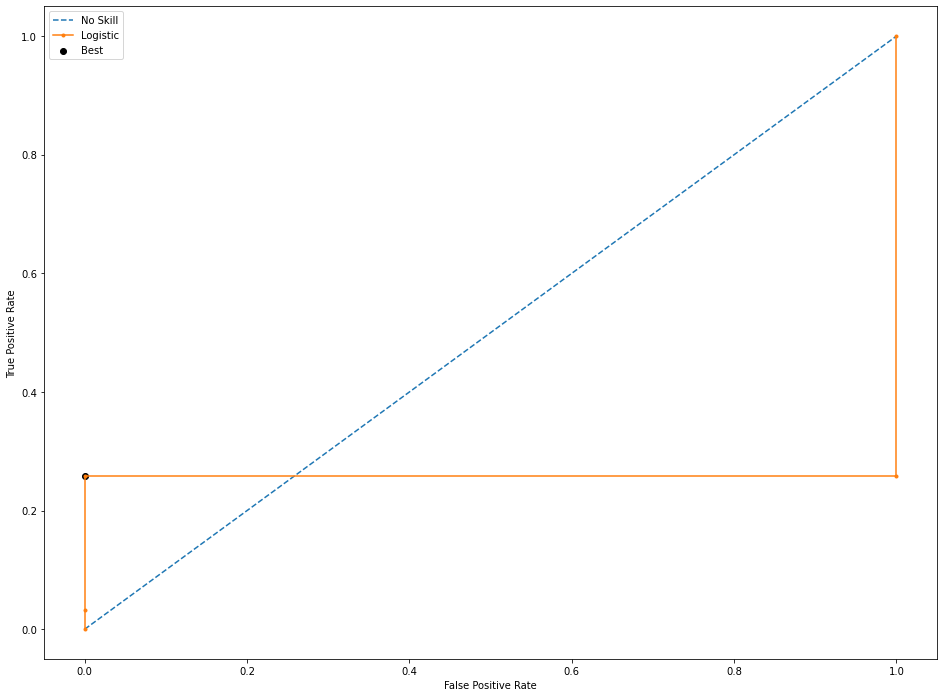

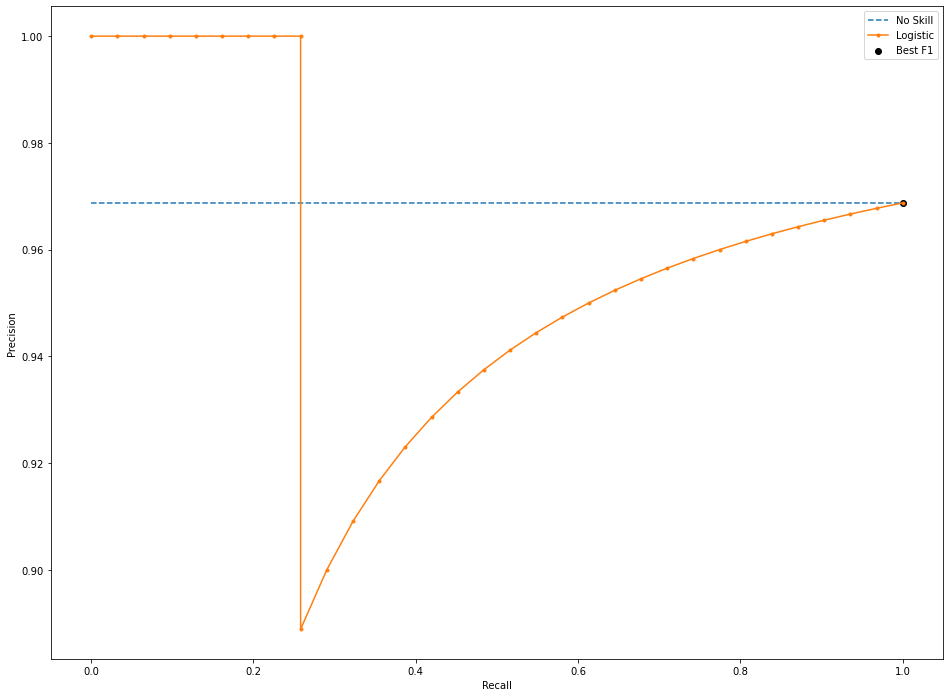

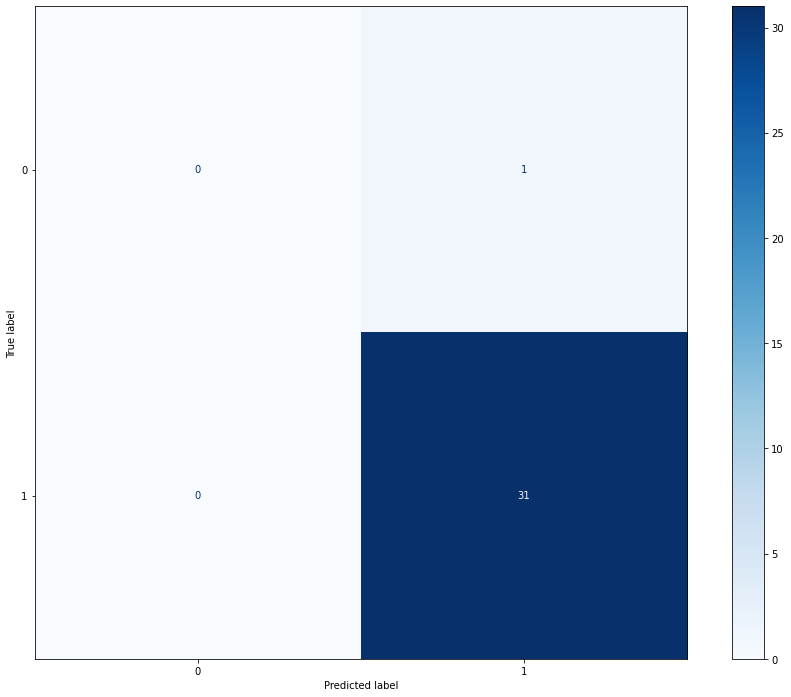

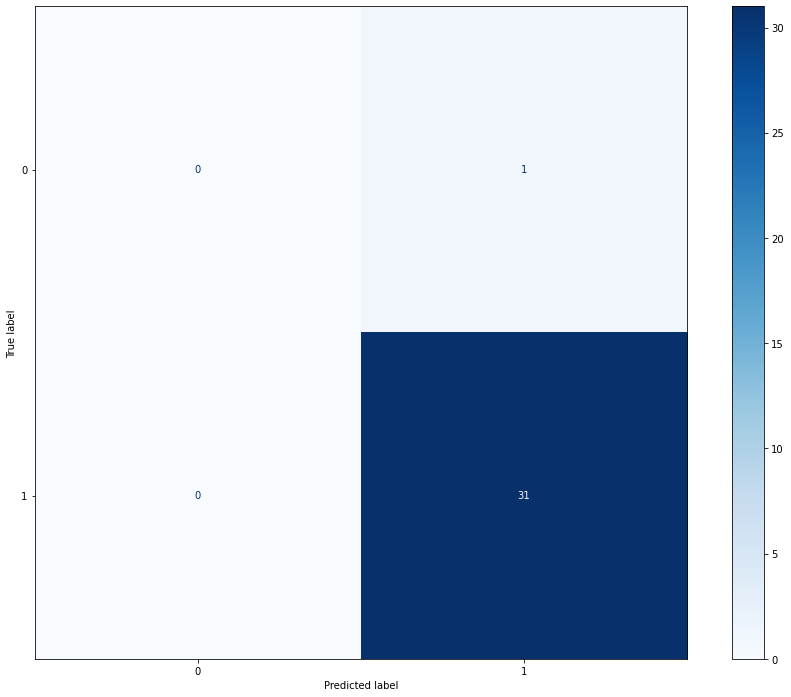

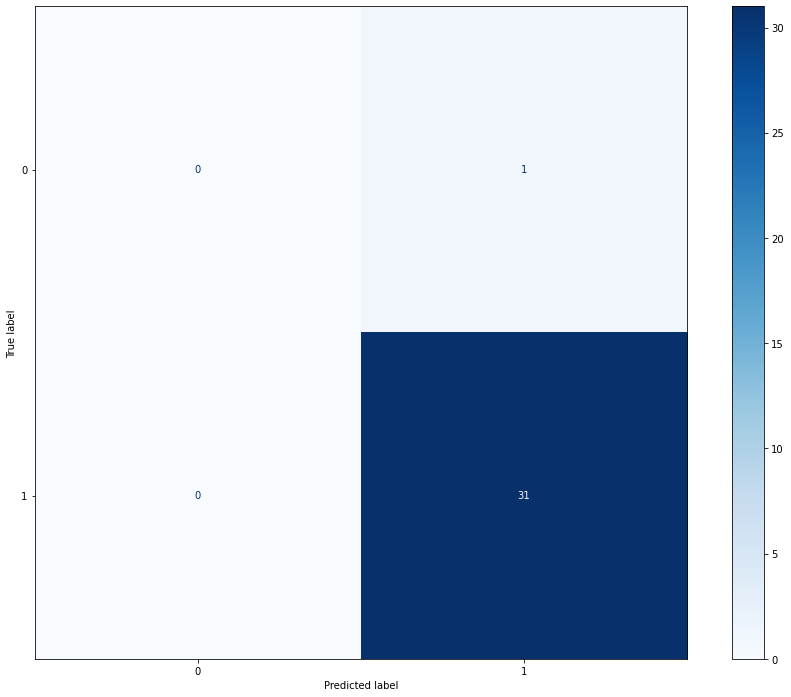

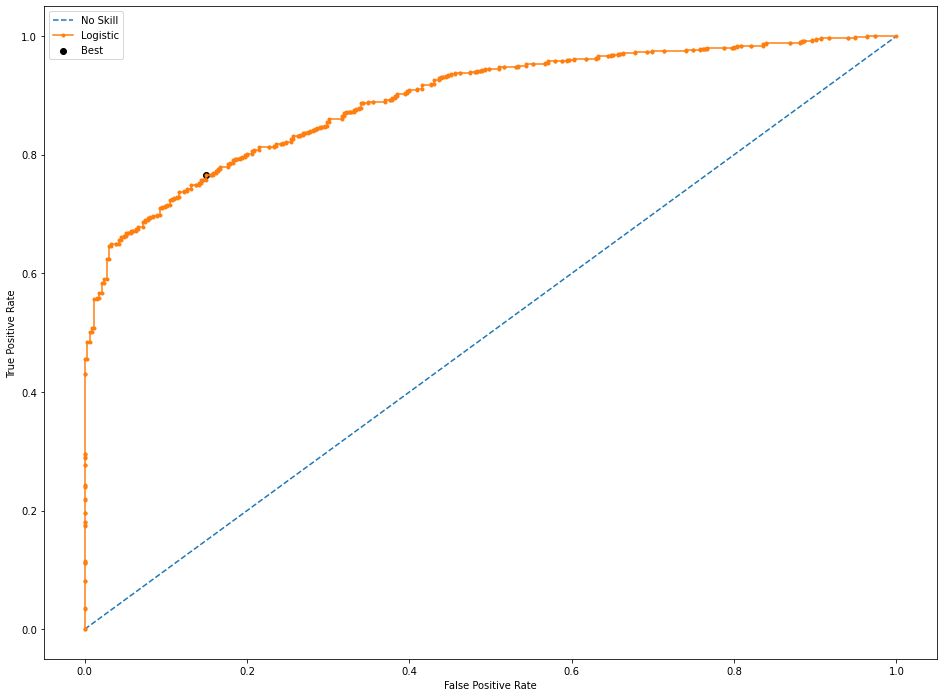

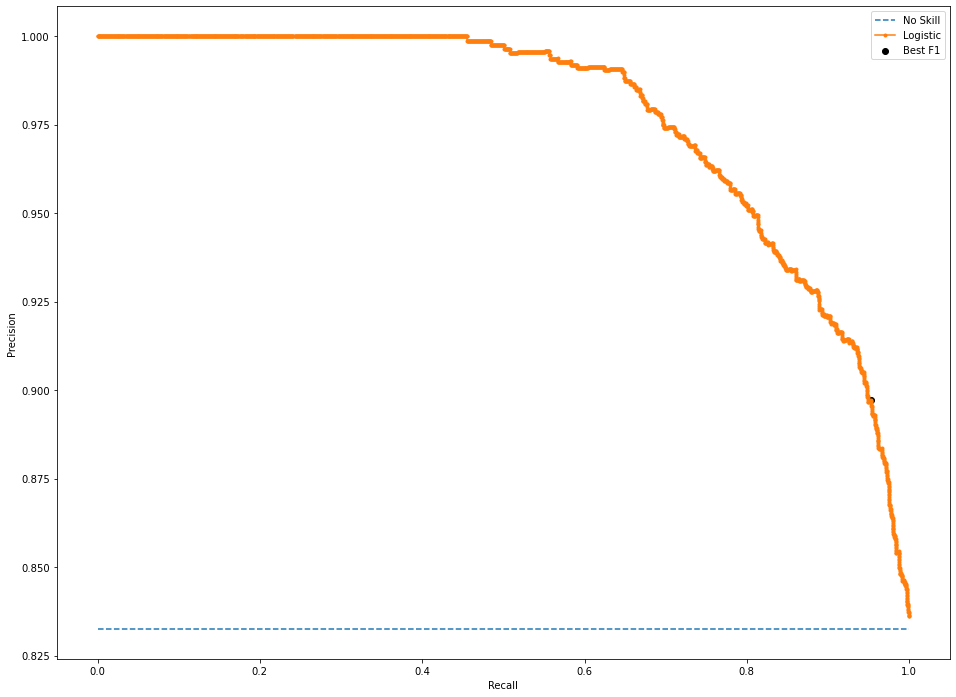

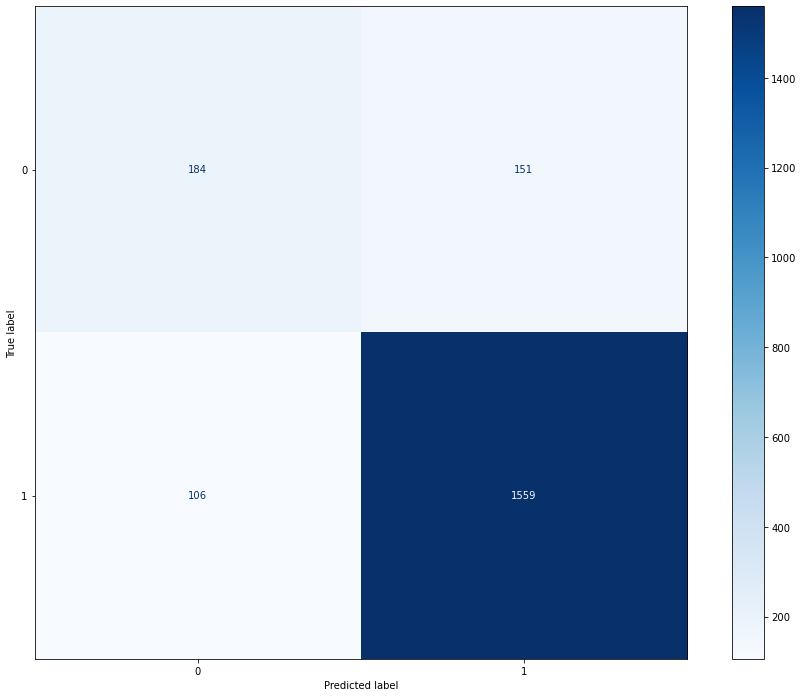

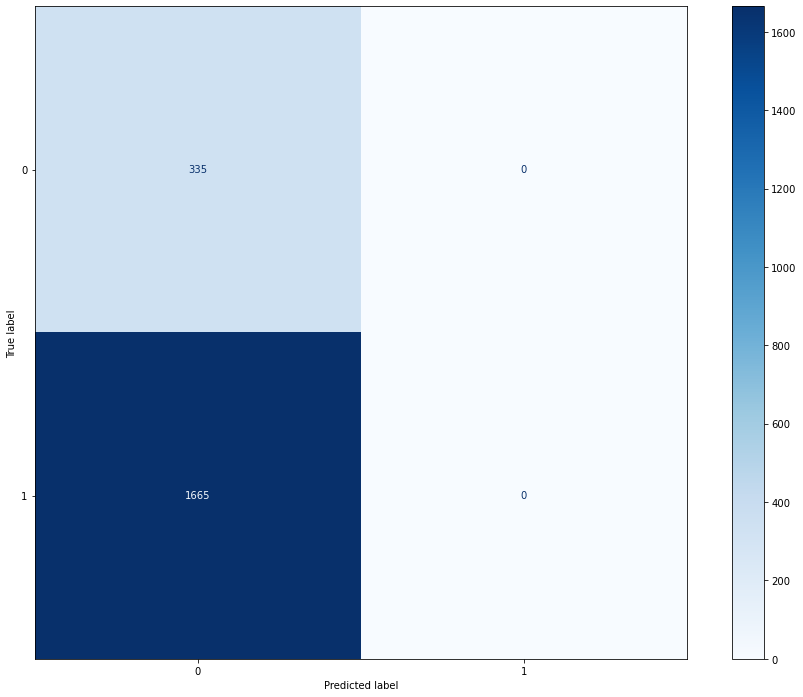

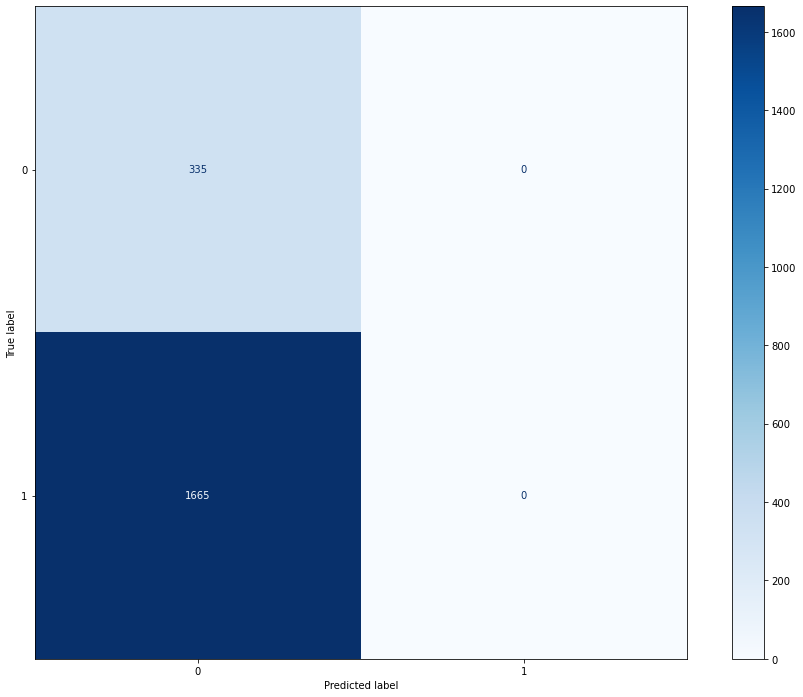

In [71]:
bin_trainer.fit(binary_classifier)

In [ ]:
bin_trainer.test(binary_classifier)

/opt/conda/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:25: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 2 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


bin_logger.experiment.stop()

In [ ]:
logger = NeptuneLogger(
    api_key=NEPTUNE_API_TOKEN,
    project_name=NEPTUNE_PROJECT_NAME,
    close_after_fit=False,
)

In [ ]:
MIN_EPOCHS = 1
MAX_EPOCHS = 6

trainer = LightningTrainer(
    gpus=GPUS,
    min_epochs=MIN_EPOCHS,
    max_epochs=MAX_EPOCHS,
    default_root_dir=CHECKPOINT_DIR,
    reload_dataloaders_every_epoch=True, # needed as we loop over a file,
    deterministic=True,
    logger=logger
)

In [ ]:
BATCH_SIZE = 4
LEARNING_RATE = 2e-05

LINEAR_SIZE = 256

DROPOUT_P = 0.2
ACTIVATION_FUNCTION = "Tanh"
WEIGHT_DECAY = 0.01 # default = 0.01

relation_classifier = RelationClassifier(
    pretrained_language_model=PRETRAINED_MODEL,
    dataset_name=DATASET_NAME,
    batch_size=BATCH_SIZE,
    learning_rate=LEARNING_RATE,
    # linear_size=LINEAR_SIZE,
    dropout_p=DROPOUT_P,
    # activation_function=ACTIVATION_FUNCTION,
    weight_decay=WEIGHT_DECAY
)

In [ ]:
trainer.fit(relation_classifier)

In [ ]:
trainer.test(relation_classifier)

## Testing 2 classifiers together

We assume the `binary_classifier` has already run test and the result is stored at `binary_classifier.proposed_answer`

In [ ]:
relation_classifier.freeze()

final_proposed_answer = []
answer = []

# with torch.cuda.device():
dataset = GenericDataset(DATASET_NAME, subset='test', batch_size=1, label_transform='none')

for i, dat in tqdm(enumerate(dataset), total=len(binary_classifier.proposed_answer)):
    answer.append(int(dat[1]))

    # if binary classifier classified as not related, do nothing further
    if binary_classifier.proposed_answer[i] == 0:
        final_proposed_answer.append(0)
        continue

    # further classify relation
    model_input = {k: torch.unsqueeze(v, dim=0).cuda() for k, v in dat[0].items()}
    logits = relation_classifier(**model_input)[0]
    final_proposed_answer.append(int(torch.argmax(logits, dim=0)) + 1)
    
final_metrics = {
    'test_combined_acc': accuracy_score(answer, final_proposed_answer),
    'test_combined_pre_micro': precision_score(answer, final_proposed_answer, average='micro'),
    'test_combined_rec_micro': recall_score(answer, final_proposed_answer, average='micro'),
    'test_combined_f1_micro': f1_score(answer, final_proposed_answer, average='micro'),
    'test_combined_pre_macro': precision_score(answer, final_proposed_answer, average='macro'),
    'test_combined_rec_macro': recall_score(answer, final_proposed_answer, average='macro'),
    'test_combined_f1_macro': f1_score(answer, final_proposed_answer, average='macro'),
}

print(json.dumps(final_metrics, indent=4))

for k, v in final_metrics.items():
    logger.experiment.log_metric(k, v)

## Run the official scorer

Some datasets comes with official scorers. We will run them in this session.

In [ ]:
class AbstractScorer(ABC):
    @abstractmethod
    def score(self, proposed_answer):
        pass

class SemEval2010Task8Scorer(AbstractScorer):
    RESULT_FILE = "semeval2010_task8_official_score.txt"
    PROPOSED_ANSWER_FILE = "semeval2010_task8_proposed_answer.txt"
    SCORER = "../input/semeval2010-task-8/SemEval2010_task8_scorer-v1.2/semeval2010_task8_scorer-v1.2.pl"
    FORMAT_CHECKER = "../input/semeval2010-task-8/SemEval2010_task8_scorer-v1.2/semeval2010_task8_format_checker.pl"
    ANSWER_KEY = "../input/semeval2010-task-8/SemEval2010_task8_testing_keys/TEST_FILE_KEY.TXT"

    def score(self, proposed_answer):

        # write test_result to file
        with open(METADATA_FILE_NAME) as f:
            metadata = json.load(f)
            id_to_label = {int(k): v for k, v in metadata[DATASET_NAME]['id_to_label'].items()}
        i = 8001
        with open(self.PROPOSED_ANSWER_FILE, "w") as f:
            for r in proposed_answer:
                f.write(f"{i}\t{id_to_label[r]}\n")
                i += 1

        # call the official scorer
        os.system(f"perl {self.FORMAT_CHECKER} {self.PROPOSED_ANSWER_FILE}")
        os.system(f"perl {self.SCORER} {self.PROPOSED_ANSWER_FILE} {self.ANSWER_KEY} > {self.RESULT_FILE}")

        # log the official score
        with open(self.RESULT_FILE) as f:
            result = f.read()
            print(result)
        logger.experiment.log_artifact(self.RESULT_FILE)

def get_official_scorer(dataset_name: str) -> AbstractScorer:
    return globals()[dataset_name + "Scorer"]()

In [ ]:
scorer = get_official_scorer(DATASET_NAME)
scorer.score(final_proposed_answer)

## Clean up



In [ ]:
logger.experiment.stop()